In [14]:
from sclibrary.network_reader import NetworkReader

data_folder = 'data/sample_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)
simplices = G.simplicies(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# if coordinates exist
filename = data_folder + '/coordinates.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")

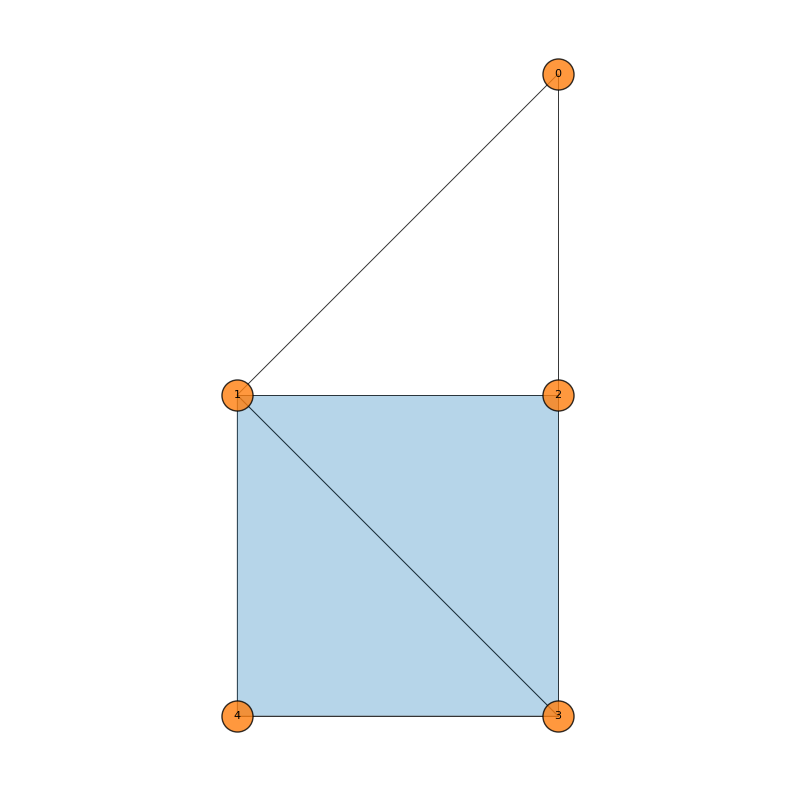

In [15]:
from sclibrary.simplicial_complex import SimplicialComplexNetwork
from matplotlib.pyplot import figure

figure(figsize=(10, 10))
sc = SimplicialComplexNetwork(simplices=simplices, pos=coordinates)

# plot
sc.plot.draw_sc_nodes(node_size=500)
sc.plot.draw_sc_edges(directed=False)
sc.plot.draw_node_labels(font_size=8)

In [6]:
from sclibrary.network_reader import NetworkReader

data_folder = 'data/london_street'

# read csv
filename = data_folder + '/LondonEdges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)
simplices = G.simplicies(condition="all")

# if coordinates exist
filename = data_folder + '/LondonNodes.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=",")

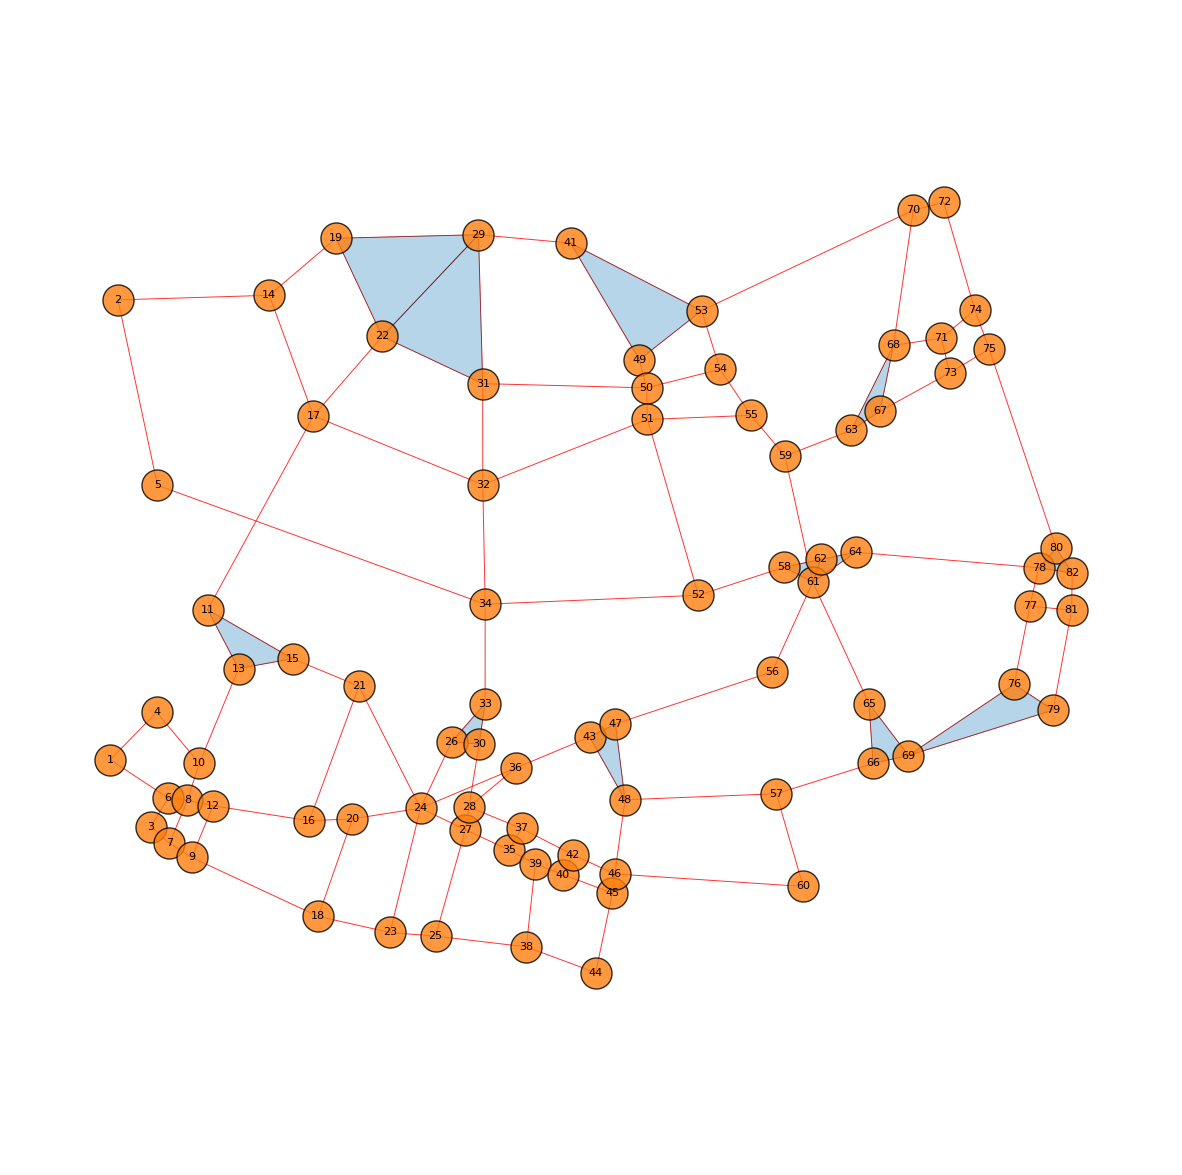

In [12]:
from sclibrary.simplicial_complex import SimplicialComplexNetwork
from matplotlib.pyplot import figure

figure(figsize=(15, 15))
sc = SimplicialComplexNetwork(simplices=simplices, pos=coordinates)

# plot
sc.plot.draw_sc_nodes(node_size=500)
sc.plot.draw_sc_edges(directed=False, arrowsize=20, edge_color="red")
sc.plot.draw_node_labels(font_size=8)